# Advance Machine Learning

## Medical Appointment Prediction

### Team Member
#### Palazzi Bruno - 806908
#### Giacomo Villa - 807462

# TO DO
 
### Attribute creation
* Creare attributo "AppointmentDay" con solo il giorno della settimana (**done**)
* Creare attributo "ScheduledHour" con solo fascia oraria di chiamata (**done**)
* Create attributo "WaitingList" con giorni di attesa tra il fissare appuntamento e giorno appuntamento (**done**)
### Analysis
* Bilanciamento Classi
* Controllo qualità dei dati (NaN value, valori anomali) ed eventuali eliminazioni
* Valutare relazioni tra dati (es: eta x no-show/si-show) 
### Optimization
* Ottimizzazione della rete su numero di neuroni per livello, ottimizzatore, parametri dell'ottimizzatore
* Valutare se utilizzate 10cv o 3cv
### Performance 
* Accuracy, recall, precision medie per le fold di test per ogni classe
* Matrici di confusione
* Curve ROC

# Libraries

In [83]:
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

import seaborn as sns

# Function

In [109]:
def get_day_period(hour):
    day_band = 0
    
    hour = int(hour)
    
    if hour >= 7 and hour <= 12:
        day_band = 0
    elif hour > 12 and hour <= 17:
        day_band = 1
    else:
        day_band = 2
        
    return day_band
    
    
def load_data():
    fields = ['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
             'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
    data = pd.read_csv('../data/appointment.csv', usecols=fields)
    print("START DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data

def from_neight_to_value(neighbourhoods):
    association = dict()
    neighbourhoods_id = list()
    id_value = 0
    
    for neighbourhood in neighbourhoods:
        if neighbourhood in association:
            neighbourhoods_id.append(association[neighbourhood])
        else:
            association[neighbourhood] = id_value
            id_value += 1
            neighbourhoods_id.append(association[neighbourhood])
    
    # print(association)
    return neighbourhoods_id
        
def from_gended_to_value(genders): 
    gender_id = list()
    
    for gender in genders:
        if gender == 'M':
            gender_id.append(0)
        elif gender == 'F':
            gender_id.append(1)
        else:
            gender_id.append(-1)
    
    return gender_id

def from_label_to_value(labels):
    label_id = list()
    
    for label in labels:
        if label == 'Yes':
            label_id.append(1)
        elif label == 'No':
            label_id.append(0)
        else:
            label_id.append(-1)
    
    return label_id

# 0: Monday 1: Tuesday 2: Wednesday 3: Thursday 4: Friday 5: Saturday 6: Sunday
# 0: Morning (7 - 12) 1: Afternoon (12 - 17) 2: Evening (17 - 22)
def attribute_creation(dataset):
    
    #### NEW ATTRIBUTES
    appointment_day = list()
    waiting_list = list()
    schedule_hour = list()
    neighbourhood = from_neight_to_value(dataset.Neighbourhood)
    gender = from_gended_to_value(dataset.Gender)
    label = from_label_to_value(dataset['No-show'])
    
    for index, row in dataset.iterrows():
        
        date1 = row['AppointmentDay'][0:10]

        
        date2 = row['ScheduledDay'][0:10]
        hour2 = row['ScheduledDay'][11:13]
        
        date1 = datetime.strptime(date1, '%Y-%m-%d')
        date2 = datetime.strptime(date2, '%Y-%m-%d')
        
        # print(date)
        # print(date.weekday())
        # print("")
        schedule_hour.append(get_day_period(hour2))
        appointment_day.append(date1.weekday())
        
        if (date1 - date2).days >= 0:
            waiting_list.append((date1 - date2).days)
            # print(date1)
            # print(date2)
            # print((date1 - date2).days)
            # print("")
        else:
            print("{:<30} {:<30}".format('Appointment Day', 'Scheduled Day'))
            print("{:<30} {:<30}".format(row['AppointmentDay'], row['ScheduledDay']))
            waiting_list.append(-1)
            print("")
    
    del dataset['ScheduledDay']
    del dataset['AppointmentDay']
    del dataset['Neighbourhood']
    del dataset['Gender']
    del dataset['No-show']
    
    dataset['appointment_day'] = appointment_day
    dataset['waiting_list'] = waiting_list
    dataset['schedule_hour'] = schedule_hour
    dataset['neighbourhood'] = neighbourhood
    dataset['gender'] = gender
    dataset['show'] = label
    
    dataset = dataset[['gender', 'schedule_hour', 'waiting_list', 'appointment_day', 'Age', 'neighbourhood', 
                      'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'show']]
    dataset.columns = ['gender', 'schedule_hour', 'waiting_list', 'appointment_day', 'age', 'neighbourhood', 
                      'scholarship', 'hipertension', 'diabetes', 'alcoholism', 'handcap', 'n_sms', 'show']
    
    dataset = dataset.drop(dataset[dataset.waiting_list < 0].index)

    
    print("FINAL DATASET")
    print(dataset.head(6))
    print("NUMBER OF ROWS: ", len(dataset))
    
    
    
    return dataset

def print_correlation_matrix(dataset):
    corr = dataset.corr()
    plt.subplots(figsize=(15, 15))
    plot = sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values,
                      linewidths=.3, vmin=-1, vmax=1, annot=True)
    
def print_distribution(dataset):
    fig1, ax1 = plt.subplots()
    number = dataset["show"].value_counts()
    print(number)
    ax1.pie([number[0], number[1]], explode = (0, 0.2), labels = ['Show', 'No Show'] , autopct='%1.1f%%', 
            shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()

# Loading Data

In [110]:
data = load_data()
complete_dataset = attribute_creation(data)

START DATASET
  Gender          ScheduledDay        AppointmentDay  Age      Neighbourhood  \
0      F  2016-04-29T18:38:08Z  2016-04-29T00:00:00Z   62    JARDIM DA PENHA   
1      M  2016-04-29T16:08:27Z  2016-04-29T00:00:00Z   56    JARDIM DA PENHA   
2      F  2016-04-29T16:19:04Z  2016-04-29T00:00:00Z   62      MATA DA PRAIA   
3      F  2016-04-29T17:29:31Z  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI   
4      F  2016-04-29T16:07:23Z  2016-04-29T00:00:00Z   56    JARDIM DA PENHA   

   Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  SMS_received  \
0            0             1         0           0        0             0   
1            0             0         0           0        0             0   
2            0             0         0           0        0             0   
3            0             0         0           0        0             0   
4            0             1         1           0        0             0   

  No-show  
0      No  
1      No  
2     

# Data Analysis

In [111]:
print(complete_dataset[0:5])

   gender  schedule_hour  waiting_list  appointment_day  age  neighbourhood  \
0       1              2             0                4   62              0   
1       0              1             0                4   56              0   
2       1              1             0                4   62              1   
3       1              1             0                4    8              2   
4       1              1             0                4   56              0   

   scholarship  hipertension  diabetes  alcoholism  handcap  n_sms  show  
0            0             1         0           0        0      0     0  
1            0             0         0           0        0      0     0  
2            0             0         0           0        0      0     0  
3            0             0         0           0        0      0     0  
4            0             1         1           0        0      0     0  


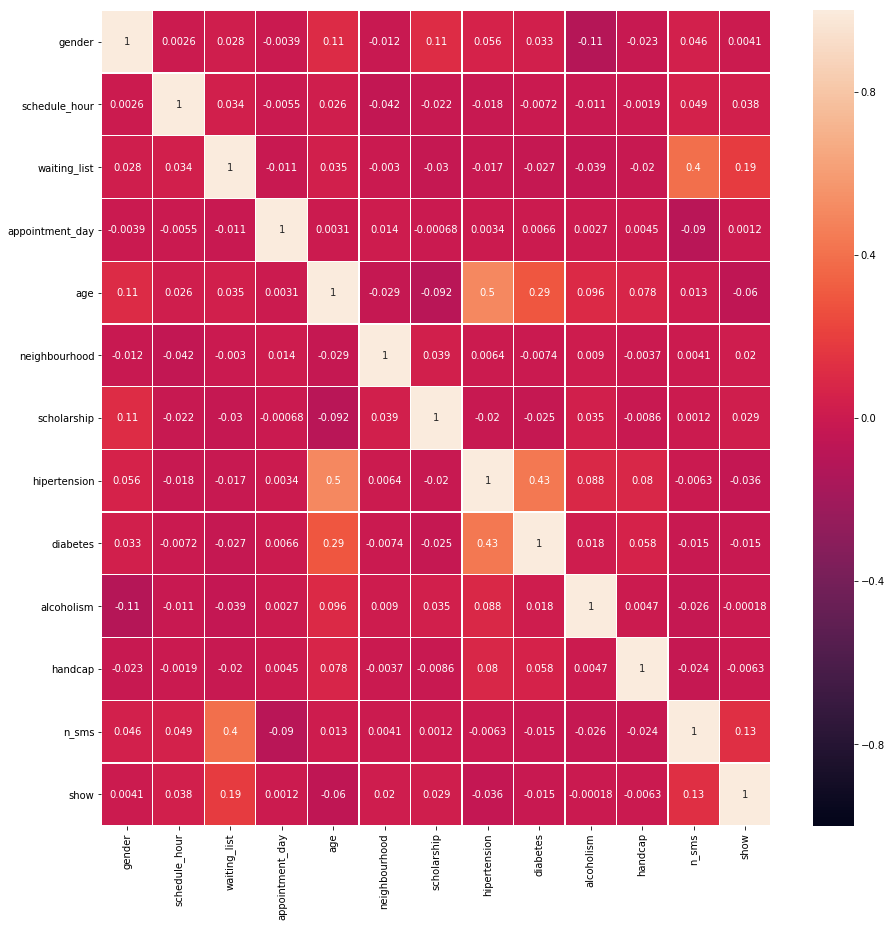

In [112]:
print_correlation_matrix(complete_dataset)

0    88208
1    22314
Name: show, dtype: int64


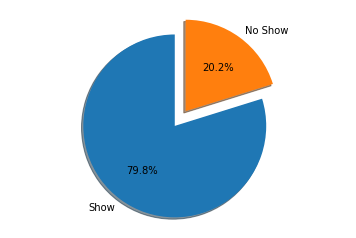

In [113]:
print_distribution(complete_dataset)

# Optimization

# Performance Analysis